In [1]:
#impot
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#chargement de nos données 
data= pd.read_csv("C:/Users/Steve/Downloads/santediag/Disease_symptom_and_patient_profile_dataset.csv")
data.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [2]:
from sklearn.preprocessing import LabelEncoder

# Créer une copie des données pour la transformation
encoded_data = data.copy()

# Liste des colonnes catégoriques
categorical_columns = ["Fever", "Cough", "Fatigue", "Difficulty Breathing", 
                       "Gender", "Blood Pressure", "Cholesterol Level", "Disease"]

# Encodage des colonnes catégoriques
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

# Gestion des classes rares dans "Disease"
disease_counts = encoded_data["Disease"].value_counts()
rare_classes = disease_counts[disease_counts < 2].index
rare_class_value = encoded_data["Disease"].max() + 1
encoded_data["Disease"] = encoded_data["Disease"].apply(lambda x: rare_class_value if x in rare_classes else x)


In [3]:
encoded_data.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,56,1,0,1,1,19,0,1,2,Positive
1,24,0,1,1,0,25,0,2,2,Negative
2,37,0,1,1,0,25,0,2,2,Negative
3,6,1,1,0,1,25,1,2,2,Positive
4,6,1,1,0,1,25,1,2,2,Positive


In [5]:
from sklearn.model_selection import train_test_split

# Séparation des caractéristiques (features) et de la variable cible
X = encoded_data.drop(columns=['Outcome Variable'])
y = encoded_data['Outcome Variable']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Initialiser le modèle
model = RandomForestClassifier(random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print("Précision :", accuracy_score(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

    Negative       0.81      0.87      0.84        30
    Positive       0.89      0.85      0.87        40

    accuracy                           0.86        70
   macro avg       0.85      0.86      0.86        70
weighted avg       0.86      0.86      0.86        70

Précision : 0.8571428571428571


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [100, 150, 200],  # Nombre d'arbres
    'max_depth': [5, 10, 15],  # Profondeur maximale
    'min_samples_split': [2, 4],  # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2],  # Nombre minimum d'échantillons dans une feuille
    'bootstrap': [True]  # Mode d'échantillonnage
}

# Création du modèle GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=['accuracy', 'f1', 'precision', 'recall'],  # Multi-métriques
    refit='accuracy',  # Utiliser l'accuracy comme métrique principale
    verbose=2,
    n_jobs=-1
)

# Entraînement avec les données
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Best parameters from GridSearchCV:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Modèle optimisé
optimized_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV:
  bootstrap: True
  max_depth: 15
  min_samples_leaf: 1
  min_samples_split: 4
  n_estimators: 100


C:\Users\Steve\anaconda\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [13]:
y_pred_optimized = optimized_model.predict(X_test)
print("Accuracy after optimization:", accuracy_score(y_test, y_pred_optimized))
y_pred_optimized = optimized_model.predict(X_test)
print("Accuracy after optimization:", accuracy_score(y_test, y_pred_optimized))


Accuracy after optimization: 0.8
Accuracy after optimization: 0.8


In [14]:
importances = model.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1]

print("Feature Importance:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Feature Importance:
Disease: 0.2841
Age: 0.2135
Cholesterol Level: 0.1245
Gender: 0.0892
Blood Pressure: 0.0714
Fever: 0.0681
Cough: 0.0520
Fatigue: 0.0504
Difficulty Breathing: 0.0468


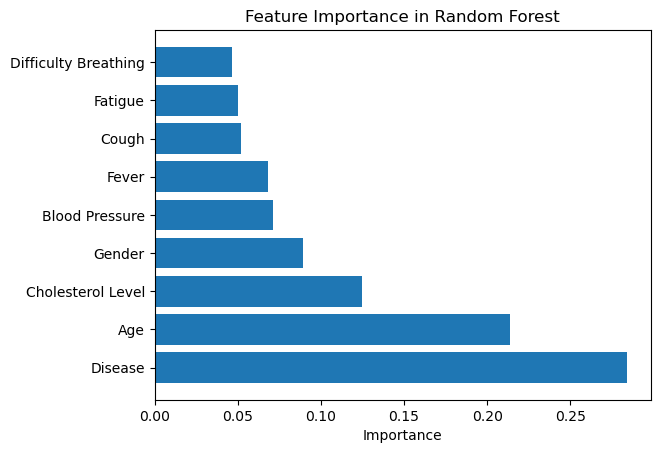

In [15]:
import matplotlib.pyplot as plt

plt.barh(feature_names[sorted_indices], importances[sorted_indices])
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()


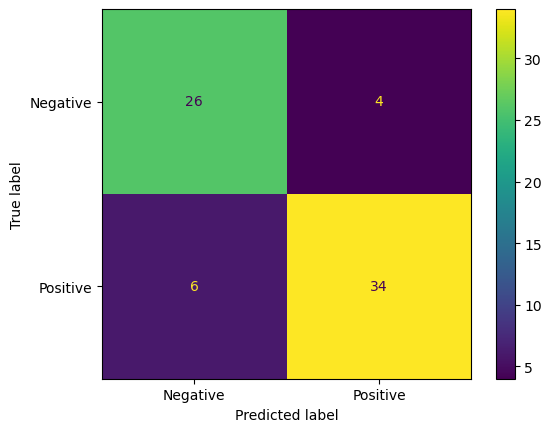

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.7        0.58571429 0.62857143 0.58571429 0.75362319]
Mean CV Accuracy: 0.6507246376811594


In [18]:
import joblib

joblib.dump(optimized_model, 'chatbot_model.pkl')


['chatbot_model.pkl']